In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import os


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
os.listdir('/content/drive/MyDrive/FootDeceisePredictionDataset')

['train_set', 'test_set']

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = (128, 128)

train_data_dir = "/content/drive/MyDrive/FootDeceisePredictionDataset/train_set"
test_data_dir = "/content/drive/MyDrive/FootDeceisePredictionDataset/test_set"


In [5]:
train_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE,
                                                         subset='training',
                                                         validation_split=0.1,
                                                         seed=42)

validation_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE,
                                                         subset='validation',
                                                         validation_split=0.1,
                                                         seed=42)

test_data = tf.keras.utils.image_dataset_from_directory(test_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE)

Found 674 files belonging to 3 classes.
Using 607 files for training.
Found 674 files belonging to 3 classes.
Using 67 files for validation.
Found 253 files belonging to 3 classes.


In [6]:
class_names = train_data.class_names
print(class_names)

['athlete-foot', 'foot-corn', 'invalid-image']


In [7]:
for image_batch, label_batch in train_data.take(1):
    print(image_batch.shape)
    print(label_batch.shape)


(32, 128, 128, 3)
(32,)


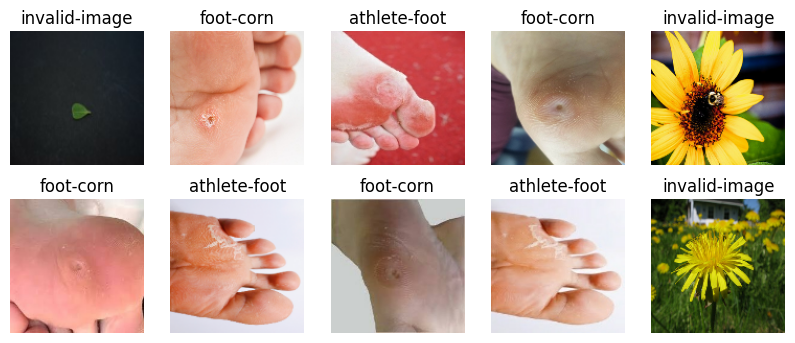

In [8]:
plt.figure(figsize=(10, 4))
for images, labels in train_data.take(1):
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [9]:
train_data = train_data.map(lambda x, y: (x / 255, y))
validation_data = validation_data.map(lambda x, y: (x / 255, y))
test_data = test_data.map(lambda x, y: (x / 255, y))


In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal", input_shape=(128, 128, 3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
# Hyperparameters
conv_filters = [32, 64, 128]
kernel_size = 3
dense_units = [128, 128, 32]
dropout_rate = 0.2
learning_rate = 0.001

In [18]:
#model
num_classes = 3

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


In [19]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 127008)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       8,128,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,129,667 (31.01 MB)

 Trainable params: 8,129,667 (31.01 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [21]:
start_time = time.time()

history = model.fit(train_data, epochs=10, validation_data=validation_data)

end_time = time.time()

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - accuracy: 0.4828 - loss: 3.8383 - val_accuracy: 0.5970 - val_loss: 0.9479
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.7043 - loss: 0.7333 - val_accuracy: 0.8060 - val_loss: 0.5100
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.8909 - loss: 0.3405 - val_accuracy: 0.8358 - val_loss: 0.4277
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9087 - loss: 0.2724 - val_accuracy: 0.8806 - val_loss: 0.2996
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9584 - loss: 0.1672 - val_accuracy: 0.9104 - val_loss: 0.2816
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9834 - loss: 0.0975 - val_accuracy: 0.9254 - val_loss: 0.2346
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.9888 - loss: 0.0620 - val_accuracy: 0.9254 - val_loss: 0.2271
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9894 - loss: 0.0552 - val_accuracy: 0.

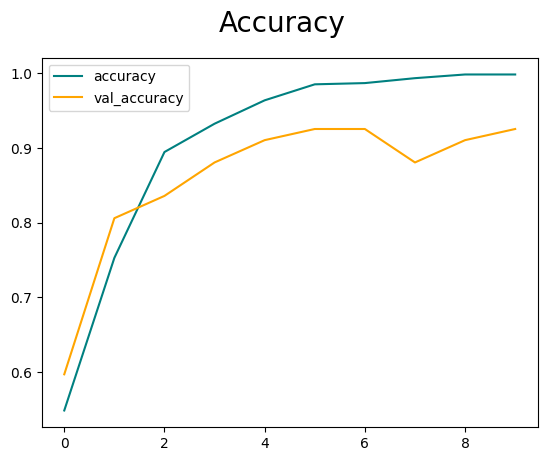

In [22]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend()
plt.show()

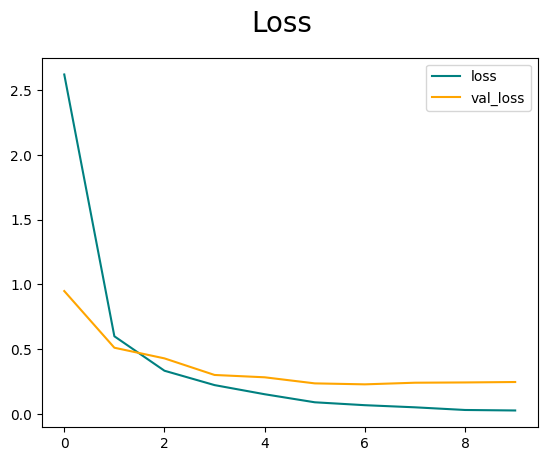

In [23]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend()
plt.show()

In [24]:
# For evaluating precision, recall, and accuracy in a multi-classes
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
accuracy = tf.keras.metrics.CategoricalAccuracy()


In [25]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    yhat = tf.argmax(yhat, axis=1)  # Convert predictions to class indices
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


In [28]:
print('Precision:', precision.result().numpy())
print('Recall:', recall.result().numpy())
print('Accuracy:', accuracy.result().numpy())


Precision: 0.9906977
Recall: 0.9551569
Accuracy: 0.875


In [30]:
# Load and preprocess an image using TensorFlow
img_path = '/content/drive/MyDrive/FootDeceisePredictionDataset/test_set/athlete-foot/athlete-foot 233.jpeg'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMAGE_SIZE)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

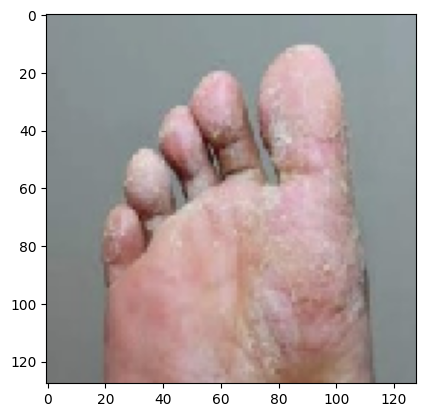

In [31]:
plt.imshow(img_array[0].numpy().astype('uint8')) # Convert the EagerTensor to a NumPy array using .numpy()
plt.show()

In [32]:
yhat = model.predict(img_array / 255)
predicted_class = np.argmax(yhat, axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


In [33]:
print(f'Predicted class: {class_names[predicted_class[0]]}')


Predicted class: athlete-foot


In [ ]:
model.save('model.h5')
